In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os import listdir

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import hsv_to_rgb

## Feature extraction from spirals and meanders

In [20]:
img = cv2.imread("./HandPD Dataset/HealthySpiral/sp1-H14.jpg")
# img = cv2.imread("./HandPD Dataset/PatientSpiral/sp2-P8.jpg")
# img = cv2.imread("./HandPD Dataset/data/PatientCircle/circA-P2.jpg")
# img = cv2.imread("./HandPD Dataset/data/PatientCircle/circA-P8.jpg")
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

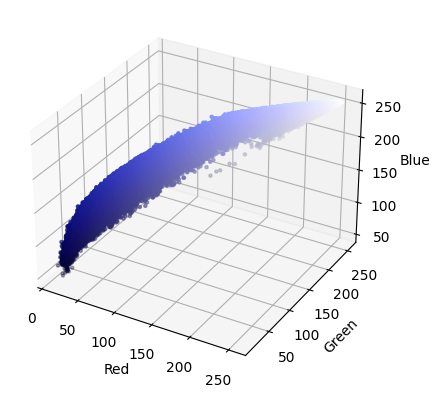

In [4]:
r, g, b = cv2.split(img)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

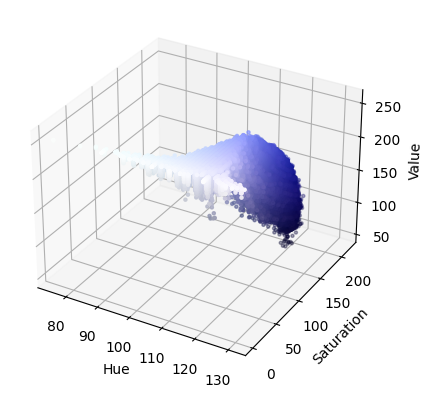

In [5]:
h, s, v = cv2.split(img_hsv)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

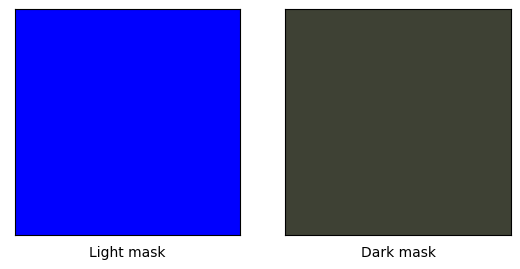

In [37]:
light = (50, 50, 65)
dark = (170, 255, 255)

lo_square = np.full((10, 10, 3), light, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.xticks([])
plt.yticks([])
plt.xlabel("Light mask")
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.xticks([])
plt.yticks([])
plt.xlabel("Dark mask")
plt.show()

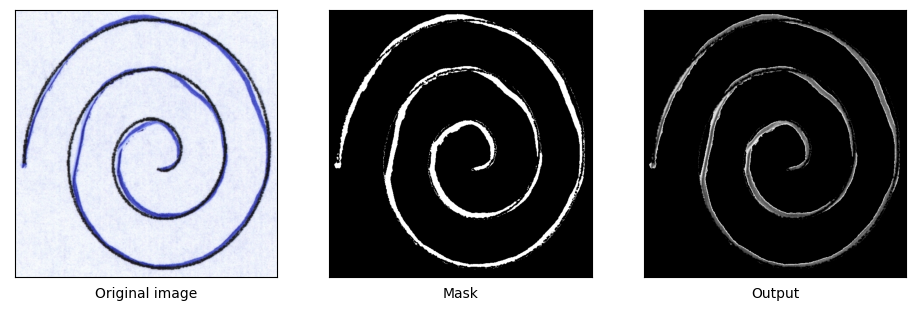

In [79]:
fig = plt.figure(figsize=(11.5, 10))
plt.xticks([])

mask = cv2.inRange(img_hsv, light, dark)
result = cv2.bitwise_and(img, img, mask=mask)

result = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
# result[result == 0] = 255

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.xlabel("Original image")
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.xlabel("Mask")
plt.subplot(1, 3, 3)
plt.imshow(result, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel("Output")
plt.show()

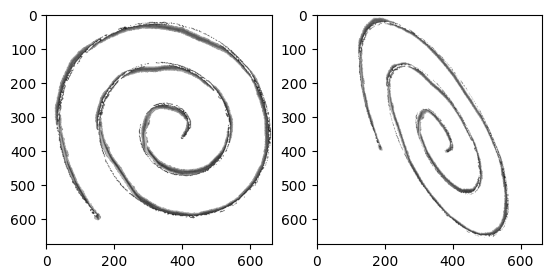

In [81]:
(h, w) = result.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), 45, 1.0)
M2 = np.array([[1, 0.8, 0],[0,1,0]])

nW =  w + abs(0.8*h)

rotated = cv2.warpAffine(result, M, (w, h))
sheared = cv2.warpAffine(result, M2, (int(nW), h))
sheared = cv2.resize(sheared, (w,h))

rotated[rotated <= 0] = 255
sheared[sheared <= 0] = 255

plt.subplot(1, 2, 1)
plt.imshow(rotated, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(sheared, cmap='gray')
plt.show()

## Preparing Data

In [148]:
def remove_template_resize(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    light = (50, 50, 65)
    dark = (170, 255, 255)
    
    mask = cv2.inRange(img_hsv, light, dark)
    result = cv2.bitwise_and(img, img, mask=mask)
    
    result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
#     result[result == 0] = 255
    
    if result.shape[0] < 256 or result.shape[1] < 256:
        min_dim = min(result.shape)
        scale = 256/min_dim
        result = cv2.resize(result, (int(result.shape[0]*scale), int(result.shape[1]*scale)))
    
    return result

In [147]:
def split_chunks_augment(img):
    output = []
    chunk_size = 128
    
    h, w = chunk_size, chunk_size
    (cX, cY) = (w // 2, h // 2)
    
    shear_factor = 0.8
    M2 = np.array([[1, shear_factor, 0],[0,1,0]])
    nW =  w + abs(shear_factor*h)
    
    for y in range(0, img.shape[0], chunk_size):
        for x in range(0, img.shape[1], chunk_size):
            if y + chunk_size <= img.shape[0] and x + chunk_size <= img.shape[1]:
                chunk = img[y:y+chunk_size, x:x+chunk_size]
                if cv2.countNonZero(chunk)  < 2*chunk_size:
                    continue
                    
                for angle in range(0, 360, 90):
                    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
                    
                    rotated = cv2.warpAffine(chunk, M, (w, h))
                    sheared = cv2.resize(cv2.warpAffine(rotated, M2, (int(nW), h)), (w, h))

                    rotated[rotated <= 0] = 255
                    sheared[sheared <= 0] = 255
                    
                    output.append(rotated)
                    output.append(sheared)
    
    return output

In [149]:
healthy = ["HealthyCircle", "HealthyMeander", "HealthySpiral"]
patient = ["PatientCircle", "PatientMeander", "PatientSpiral"]

X = []
y = []

for directory in healthy:
    for k, img_file in tqdm(enumerate(listdir(f"./HandPD Dataset/{directory}")), desc=directory):
        img = cv2.imread(f"./HandPD Dataset/{directory}/{img_file}")
        
        img = remove_template_resize(img)
        for i, chunk in enumerate(split_chunks_augment(img)):
            cv2.imwrite(f"./HandPD Dataset/data_chunked/Healthy/H-{str(k)}_{str(i)}.png", chunk)
#             X.append(chunk)
#             y.append(0)

for directory in patient:
    for k, img_file in tqdm(enumerate(listdir(f"./HandPD Dataset/{directory}")), desc=directory):
        img = cv2.imread(f"./HandPD Dataset/{directory}/{img_file}")
        
        img = remove_template_resize(img)
        for i, chunk in enumerate(split_chunks_augment(img)):
            cv2.imwrite(f"./HandPD Dataset/data_chunked/Patient/P-{str(k)}_{str(i)}.png", chunk)
#             X.append(chunk)
#             y.append(1)

HealthyCircle: 35it [00:02, 16.86it/s]
HealthyMeander: 140it [00:21,  6.54it/s]
HealthySpiral: 140it [00:25,  5.51it/s]
PatientCircle: 31it [00:02, 15.15it/s]
PatientMeander: 124it [00:23,  5.17it/s]
PatientSpiral: 124it [00:30,  4.03it/s]


## Train the model

In [150]:
import tensorflow as tf
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [118]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [119]:
data_dir = './HandPD Dataset/data_chunked' 

In [120]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)
print(data)

Found 82032 files belonging to 2 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [121]:
data_iterator = data.as_numpy_iterator()

In [127]:
batch = data_iterator.next()

In [132]:
len(batch[0])

32

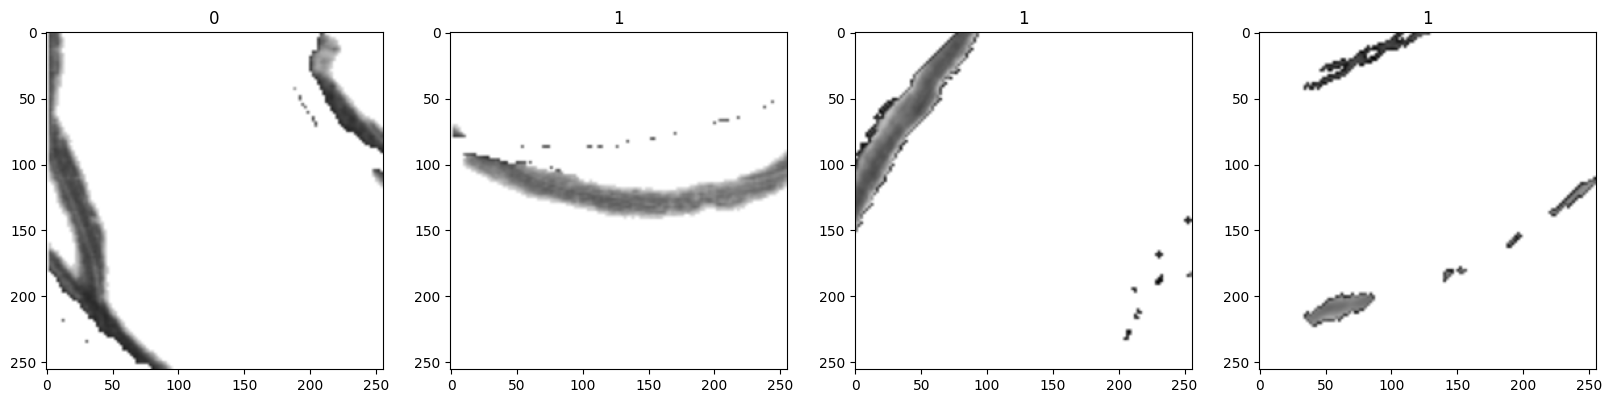

In [135]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][8:12]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [136]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [137]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.1)
test_size = int(len(data)*.2)

In [138]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [139]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [141]:
model = Sequential()

In [142]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (5,5), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (5,5), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [143]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [144]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 16)        12816     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 16)       0

In [145]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [146]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
 155/1794 [=>............................] - ETA: 50:12 - loss: 0.6978 - accuracy: 0.5258

KeyboardInterrupt: 

### Plot Performance

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
# plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
# plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())